### 目标

将合适的电影推荐给用户。

### 数据

- 用户对电影的评分
- 电影本身的信息

### 推荐方法

- collaborative filtering（协同过滤）：只根据用户对电影的评分，找出品味相近的用户A和B，将A对其评分高而B未看过的电影推荐给B
    - 优点：准确地预测复杂的事物（而无需了解其内容）
    - 缺点：相似性计算要求很大数据量和强计算能力
- content filtering（内容过滤）：结合用户对电影的评分和电影信息，若A喜欢看电影X，X由演员B主演，可以将B主演的其它电影推荐给A
    - 优点：无需那么大的数据量
    - 缺点：预测能力有限，因难以了解复杂事物的内容
- hybrid recommendation systems：两种方法的结合
    - 步骤1：发现A和B的喜好相似
    - 步骤2：发现A和B共同喜欢的电影C与它们都未看过的电影D在演员、风格上都相近
    - 步骤3：将D推荐给A和B
    - 优点：做到了只用其中一种方法实现不了的事
        - 在A和B都没有看过电影D的情况下，向A和B推荐电影D（collaborative filtering只有在A看过时才能向B推荐）
        - 将一部电影推荐给两个人（content filtering只能一次推荐给一人）

### 内容过滤实践

- 数据：MovieLens中的电影被划分为18个类型，包括unknown。每部电影可能被归为多个类型
- 目的：找到类型相近的电影
- 方法：聚类（非监督学习方法）模型，将相近（用距离度量）的数据点尽可能归为一类。聚类模型不预测结果，但可以用于优化预测结果。在某一类中使用预测模型，能提高预测模型的准确度。将学习最常用Hierarchical clustering（层次聚类）和k-means。
- 点间距度量
    - 欧氏距离
    - 曼哈顿距离（用绝对值取代平方，源于曼哈顿的网格状布局）
    - 切比雪夫距离（各坐标数值差的最大值）
- 类间距度量
    - 最小距离（找到类A中点a与类B中点b，使得二者距离最小）
    - 最大距离（找到类A中点a与类B中点b，使得二者距离最大）
    - centriod distance（中心距离，类间中心的欧氏距离）

#### 层次聚类

- 使用间距度量：欧氏距离和中心距离。
- 算法：找出距离最小的两个类（若二者为均为单点，使用欧氏距离，否则使用中心距离），聚为新类，直至所有数据被聚为一类。
- dendrogram：算法逐次将两个旧类聚为一个新类。dendrogram中竖线的的高度代表“当两个类被聚为一类时，旧类与新类的类间距”。用水平的线去截树，可以得出特定类数目下的聚类结果。在下图中，聚为两类的情况，水平线可以上下滑动的距离大，说明两类合并为一类时，两个类的类间距很大，则说明两个类区别很大，则选择将数据总体分为两类是好的选择。反之，分为三类并不是好选择。

![层次聚类树](http://static.zybuluo.com/cys/7mb6rj70sduw2vp2lhzwvp96/image_1ak14cef35hbli41tdu1qec1htgm.png)

下面使用层次聚类进行内容过滤。`header=FALSE`因为文件中无属性名字行；`quote`保证正确读入。

In [1]:
movies = read.table("./data/movieLens.txt", header=FALSE, sep="|", quote="\"")
str(movies)

'data.frame':	1682 obs. of  24 variables:
 $ V1 : int  1 2 3 4 5 6 7 8 9 10 ...
 $ V2 : Factor w/ 1664 levels "Metisse (Caf锟\xbd au Lait) (1993)",..: 1524 618 555 594 343 1317 1544 112 391 1239 ...
 $ V3 : Factor w/ 241 levels "","01-Aug-1997",..: 71 71 71 71 71 71 71 71 71 182 ...
 $ V4 : logi  NA NA NA NA NA NA ...
 $ V5 : Factor w/ 1661 levels "","http://us.imdb.com/M/title-exact/Independence%20(1997)",..: 1431 565 505 543 310 1661 1453 103 357 1183 ...
 $ V6 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ V7 : int  0 1 0 1 0 0 0 0 0 0 ...
 $ V8 : int  0 1 0 0 0 0 0 0 0 0 ...
 $ V9 : int  1 0 0 0 0 0 0 0 0 0 ...
 $ V10: int  1 0 0 0 0 0 0 1 0 0 ...
 $ V11: int  1 0 0 1 0 0 0 1 0 0 ...
 $ V12: int  0 0 0 0 1 0 0 0 0 0 ...
 $ V13: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V14: int  0 0 0 1 1 1 1 1 1 1 ...
 $ V15: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V16: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V17: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V18: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V19: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V20: int  0 0 0 0 

加入列名。

In [2]:
colnames(movies) = c("ID", "Title", "ReleaseDate", "VideoReleaseDate", "IMDB", "Unknown", "Action", "Adventure", "Animation", "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "FilmNoir", "Horror", "Musical", "Mystery", "Romance", "SciFi", "Thriller", "War", "Western")
str(movies)

'data.frame':	1682 obs. of  24 variables:
 $ ID              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Title           : Factor w/ 1664 levels "Metisse (Caf锟\xbd au Lait) (1993)",..: 1524 618 555 594 343 1317 1544 112 391 1239 ...
 $ ReleaseDate     : Factor w/ 241 levels "","01-Aug-1997",..: 71 71 71 71 71 71 71 71 71 182 ...
 $ VideoReleaseDate: logi  NA NA NA NA NA NA ...
 $ IMDB            : Factor w/ 1661 levels "","http://us.imdb.com/M/title-exact/Independence%20(1997)",..: 1431 565 505 543 310 1661 1453 103 357 1183 ...
 $ Unknown         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Action          : int  0 1 0 1 0 0 0 0 0 0 ...
 $ Adventure       : int  0 1 0 0 0 0 0 0 0 0 ...
 $ Animation       : int  1 0 0 0 0 0 0 0 0 0 ...
 $ Childrens       : int  1 0 0 0 0 0 0 1 0 0 ...
 $ Comedy          : int  1 0 0 1 0 0 0 1 0 0 ...
 $ Crime           : int  0 0 0 0 1 0 0 0 0 0 ...
 $ Documentary     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Drama           : int  0 0 0 1 1 1 1 1 1 1 ...
 $ Fantasy         : int

不需要的数据，设为`NULL`。此外，去重。

In [3]:
movies$ID = NULL
movies$ReleaseDate = NULL
movies$VideoReleaseDate = NULL
movies$IMDB = NULL
movies = unique(movies)

得到电影所属的流派。

In [4]:
str(movies)

'data.frame':	1664 obs. of  20 variables:
 $ Title      : Factor w/ 1664 levels "Metisse (Caf锟\xbd au Lait) (1993)",..: 1524 618 555 594 343 1317 1544 112 391 1239 ...
 $ Unknown    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Action     : int  0 1 0 1 0 0 0 0 0 0 ...
 $ Adventure  : int  0 1 0 0 0 0 0 0 0 0 ...
 $ Animation  : int  1 0 0 0 0 0 0 0 0 0 ...
 $ Childrens  : int  1 0 0 0 0 0 0 1 0 0 ...
 $ Comedy     : int  1 0 0 1 0 0 0 1 0 0 ...
 $ Crime      : int  0 0 0 0 1 0 0 0 0 0 ...
 $ Documentary: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Drama      : int  0 0 0 1 1 1 1 1 1 1 ...
 $ Fantasy    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ FilmNoir   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Horror     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Musical    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Mystery    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Romance    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SciFi      : int  0 0 0 0 0 0 1 0 0 0 ...
 $ Thriller   : int  0 1 1 0 1 0 0 0 0 0 ...
 $ War        : int  0 0 0 0 0 0 0 0 0 1 ...
 $ Western    : int  0

使用层次聚类，将电影按流派进行聚类。聚类结果将用于推荐。

首先计算所有点之间的距离（只考虑流派，故取2-20列）。随后使用`hclust`和`ward.D`进行层次聚类。

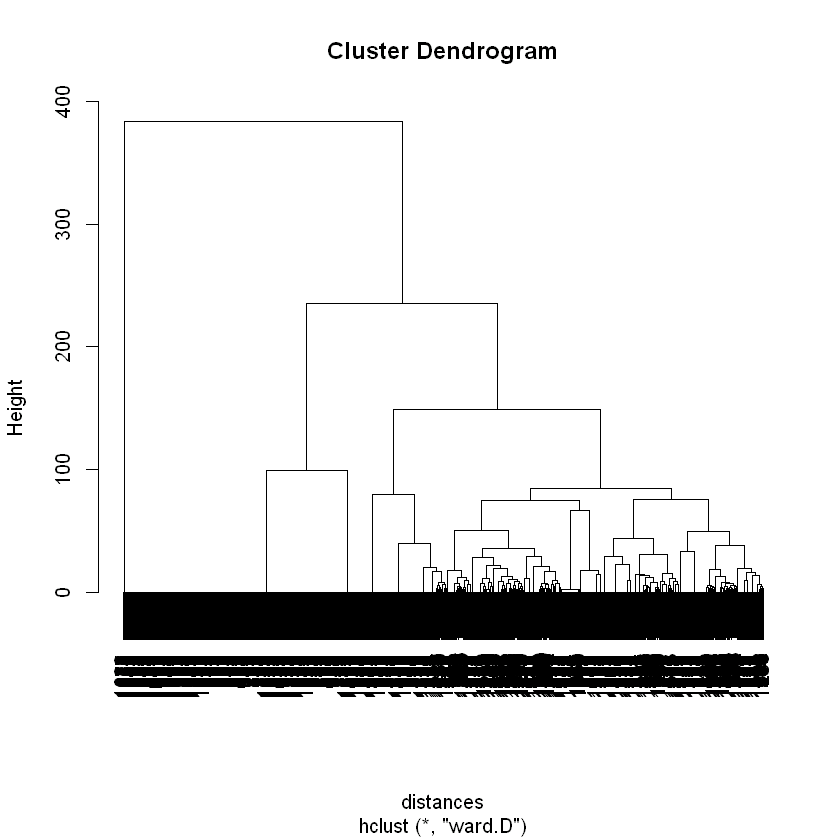

In [9]:
distances = dist(movies[2:20], method="euclidean")
clusterMovies = hclust(distances, method="ward.D")
plot(clusterMovies)

不妨考虑将数据聚为十个类。`cutree`根据某一数据点被聚到哪一类，对它进行标记。

In [10]:
clusterGroups = cutree(clusterMovies, k=10)

计算在10个类中，流派为`Action`的电影的比例。第2类中，78%的电影的流派是`Action`。

In [11]:
tapply(movies$Action, clusterGroups, mean)

1         2         3         4         5         6         7         8 
0.1784512 0.7839196 0.1238532 0.0000000 0.0000000 0.1015625 0.0000000 0.0000000 
        9        10 
0.0000000 0.0000000

使用以上的`tapply`方法，则对每一个列属性都要执行一条指令。下面介绍对每一类执行一条指令的方法`colMeans`（mean of columns, 对列求均值）。

In [18]:
colMeans(subset(movies[2:20], clusterGroups==1))

Unknown      Action   Adventure   Animation   Childrens      Comedy 
0.006734007 0.178451178 0.185185185 0.134680135 0.393939394 0.363636364 
      Crime Documentary       Drama     Fantasy    FilmNoir      Horror 
0.033670034 0.010101010 0.306397306 0.070707071 0.000000000 0.016835017 
    Musical     Mystery     Romance       SciFi    Thriller         War 
0.188552189 0.000000000 0.104377104 0.074074074 0.040404040 0.225589226 
    Western 
0.090909091

一共聚为10类，则该指令要执行十次，也很麻烦。可以用`split`来替代`subset`，它在语法上更简单。但还是要执行10次，才能生成想要的全表。

In [20]:
spl = split(movies[2:20], clusterGroups)
colMeans(spl[[1]])

Unknown      Action   Adventure   Animation   Childrens      Comedy 
0.006734007 0.178451178 0.185185185 0.134680135 0.393939394 0.363636364 
      Crime Documentary       Drama     Fantasy    FilmNoir      Horror 
0.033670034 0.010101010 0.306397306 0.070707071 0.000000000 0.016835017 
    Musical     Mystery     Romance       SciFi    Thriller         War 
0.188552189 0.000000000 0.104377104 0.074074074 0.040404040 0.225589226 
    Western 
0.090909091

`lapply(spl, colMeans)`将`colMeans`作用在`spl`的每一个元素上，生成在所有类中，各种流派的电影所占的比重。语法最简单，而且只需执行一条指令。

下面只取第一类中的结果。

In [24]:
lapply(spl, colMeans)[1]

$`1`
    Unknown      Action   Adventure   Animation   Childrens      Comedy 
0.006734007 0.178451178 0.185185185 0.134680135 0.393939394 0.363636364 
      Crime Documentary       Drama     Fantasy    FilmNoir      Horror 
0.033670034 0.010101010 0.306397306 0.070707071 0.000000000 0.016835017 
    Musical     Mystery     Romance       SciFi    Thriller         War 
0.188552189 0.000000000 0.104377104 0.074074074 0.040404040 0.225589226 
    Western 
0.090909091

找出Amy喜欢的`Men in Black (1997)`所在的类。

In [12]:
subset(movies, Title=="Men in Black (1997)")

,Title,Unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
257,Men in Black (1997),0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [13]:
clusterGroups[257]

257 
  2

第二类中有哪些电影？

In [17]:
cluster2 = subset(movies, clusterGroups == 2)
cluster2$Title[1:10]

[1] GoldenEye (1995)                              
 [2] Bad Boys (1995)                               
 [3] Apollo 13 (1995)                              
 [4] Net, The (1995)                               
 [5] Natural Born Killers (1994)                   
 [6] Outbreak (1995)                               
 [7] Stargate (1994)                               
 [8] Fugitive, The (1993)                          
 [9] Jurassic Park (1993)                          
[10] Robert A. Heinlein's The Puppet Masters (1994)
1664 Levels: Metisse (Caf锟\xbd au Lait) (1993) ... C'est arriv锟\xbd pr閼\xa3 de chez vous (1992)